## 1.Reliability Fusion Map (RFM)

<br>

1. `matrix` is global variable from csv file <br>
    `f1, f2, f3...` is CNN confidence vector; <br>
    `p` = CNN predict label; <br>
    `y` = label of patch; <br>
    `texture_quality` = patch texture quality factor, see formula(2) in paper
    <hr>
    
2. Fusion step: `filter_texture()`->`fushion_map()`->`fusion_denisty()`; <br>
    `filter_texture()`: filter low texture patch predictions of CNN, we set threshold_texture=0;<br>
    `fushion_map()`: fusion step1, see formula(3) in paper; <br>
    `fusion_denisty()`: fusion step2, see formula(4), (5) in paper; <br>
    <hr>

3. Output matrix structure is the same as input matrix <br>
    <hr>
    
## 2.About 

This is tampering detection experiment for RFM algorithm (see experiment 1-1 in paper). <br>


> $matrix=[f1, f2, f3, f4, f5... p, y, texture_quality]

In [287]:
import os, math, seaborn as sns, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg
from collections import Counter
sns.set()

# Detection for RFM algorithm, experiment 1 in paper
# matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]

In [257]:
root_path = "/data/experiment"
scope_name = "pre-train_32x32"

In [278]:
def filter_texture(matrix, label, threshold=0.4):
    '''
    Filter low texture patches
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    # get placeholder
    flag = (matrix[:, 7] < threshold)
    matrix[flag, :5] = 0
    matrix[flag, label] = 1
    return matrix

def fushion_map(matrix, w, h):
    '''
    Fusion step1: F & Q
    After fusion，w=w-1, h=h-1, texture_quality，label=4个取投票
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    matrix = np.reshape(matrix, (h, w, -1))
    result = np.zeros((h-1, w-1, 7))
    offset = [[0,0], [0,1], [1,0], [1,1]]
    
    for j in range(h - 1):
        for i in range(w - 1):
            # temp matrix
            tmp_matrix = np.zeros([5])
            total = matrix[j, i, 7] + matrix[j, i+1, 7] + matrix[j+1, i, 7] + matrix[j+1, i+1, 7]
            for p in offset:
                tmp_matrix += (matrix[j+p[0], i+p[1], :5]) * (matrix[j+p[0], i+p[1], 7] / total)
            
            # append result to F confidence
            result[j, i, :5] = tmp_matrix
            result[j, i, 5] = np.array(np.argmax(result[j, i, :5]), dtype=np.int32)
            
            label_map = []
            for p in offset:
                label_map.append(int(matrix[j+p[0], i+p[1], 6]))
            result[j, i, 6] = Counter(label_map).most_common()[0][0]
    return np.reshape(result, ((w-1) * (h-1), 7))

def fusion_denisty(matrix, w, h, label, threshold=0.6):
    '''
    Fusion step2: R & ρ
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    flag = np.where(matrix[:, 5] != label)
    matrix = np.reshape(matrix, (h, w, -1))
    source_matrix = matrix.copy()
    
    offset = [
        [-1, -1], [-1, 0], [-1, 1], 
        [0, -1], [0, 1], 
        [1, -1], [1, 0], [1, 1]
    ]
    for index in list(flag[0]):
        x = int(index % w)
        y = int(index / w)
        
        length, cnt = 0, 0
        for p in offset:
            _x = x + p[1]
            _y = y + p[0]
            
            # 检测是否在边界，如果不是边界要计算
            if (_x >= 0) and (_y >= 0) and (_x < w) and (_y < h):
                cnt += 1
                # add check length+1
                if source_matrix[_y][_x][5] != label:
                    length += 1

        # 对于周围分数过低的点，修改标签+过滤
        if float(length / cnt) < threshold:
            matrix[y, x, :5] = 0
            matrix[y, x, label] = 1
            matrix[y, x, 5] = label
    return np.reshape(matrix, (w*h, -1))

def show_map(matrix, w, h, threshold=0):
    '''
    Show hot map
    @matrix=[f1, f2, f3, f4, f5, p, y]
    '''
    plt.clf()
    # 计算label
    label = np.argmax(np.bincount(np.array(matrix[:, 5], dtype=np.int32)))
    label_list = np.ones([w*h], dtype=np.int32) * label
    predict_list = matrix[0: w*h, 5]
    
    diff_matrix = np.array(np.abs(label_list - predict_list), dtype=np.bool) * 1
    conf_matrix = np.max(matrix[:, 0:5], axis=1)
    
    list_matrix = np.multiply(conf_matrix, diff_matrix)
    list_matrix[list_matrix < threshold] = 0
    
    xmap = np.reshape(list_matrix, (h, w))
    return sns.heatmap(xmap, linewidths=.01, cmap='YlGnBu')

score = {}

In [ ]:
'''
scan all csv files, output detection result
ctype="pre-train_32x32" is forged images CNN csv output;
ctype="pre-train-true_32x32" is pristine images CNN csv output
'''

cnt1, cnt2, f_cnt1, err_cnt1, rate1, f_cnt2, err_cnt2, rate2, score1, score2 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
ctypes = ["pre-train_32x32", "pre-train-true_32x32"]

def detection(ctype, threshold=0.009, threshold_texture=0.4, threshold_density=0.6, debug=True):
    '''
    @return [篡改数，错判数，平均篡改率]
    '''
    # init variables
    count, total_rate, error_count, forged_count, score = 0, 0, 0, 0, []
    csv_root_path = os.path.join(root_Path, ctype)
    
    print("=> start:`{:s}` path={:s}\n".format(ctype, csv_root_path))
    for name in os.listdir(csv_root_path):
        (_w, _h) = (int(int(name.split("_")[-2])), int(int(name.split("_")[-1].split(".")[-2])))
        (w, h) = int(_w / 32 - 1), int(_h / 32 - 1)

        # @raw_data=[f1, f2, f3, f4, f5, p, y, texture]
        raw_data = pd.read_csv(os.path.join(root_path, ctype, name)).values[:w*h, 1:9]    
        # get_label
        label = int(np.argmax(np.bincount(np.array(raw_data[:, 5], dtype=np.int32))))

        # filter texture
        if threshold_texture > 0:
            texture_data = filter_texture(raw_data, label, threshold=threshold_texture)
        else:
            texture_data = raw_data
        
        # fusion step1: F & Q
        fusion_data = fushion_map(texture_data, w, h)
        # fusion step2: R & ρ
        density_data = fusion_denisty(fusion_data, w-1, h-1, label, threshold=threshold_density)

        # label y and predict ŷ
        y_vector = np.ones([density_data.shape[0]], dtype=np.int32) * label
        y_hat_vector = np.array(density_data[:, 5], dtype=np.int32)

        diff_rate = 1 - np.sum(np.equal(y_vector, y_hat_vector)) / y_vector.shape[0]
        score.append(diff_rate)
        total_rate += diff_rate
        
        # final classification
        if diff_rate > threshold:
            # 大于阈值，判定篡改
            forged_count += 1
            # 对于无篡改样本，错判+1
            if ctype == ctypes[1]:
                error_count += 1
        else:
            # 对于篡改样本，错判+1
            if ctype == ctypes[0]:
                error_count += 1
        count += 1   
        if debug:
            print("=> id={:d} diff_rate={:.4f}, total_diff_rate={:.4f}".format(count, diff_rate, total_rate / count))    
    return count, forged_count, error_count, total_rate / count, np.array(score, dtype=np.float32)

# define threshold, texture, denisty
t, t_texture, t_density = 0.009, 0.4, 0.4

key = "{0}_{1}".format(t, t_density)
score[key] = [0, 0]

cnt1, f_cnt1, err_cnt1, rate1, score[key][0] = detection(ctypes[0], threshold=t, threshold_texture=t_texture, threshold_density=t_density, debug=True)
cnt2, f_cnt2, err_cnt2, rate2, score[key][1] = detection(ctypes[1], threshold=t, threshold_texture=t_texture, threshold_density=t_density, debug=True)

print("=> 篡改=({:d},{:d}) 错误=({:d},{:d}) 篡改率=({:.4f},{:.4f})".format(
        f_cnt1, f_cnt2, err_cnt1, err_cnt2, rate1, rate2
    )
)
print("=> 篡改={:d} 错误={:d} 正确率={:.4f}".format(
        f_cnt1 + f_cnt2, err_cnt1 + err_cnt2, 1 - (err_cnt1 + err_cnt2) / 801
    )
)

=> start:`pre-train_32x32` path=/data/experiment/pre-train_32x32

=> id=1 diff_rate=0.0187, total_diff_rate=0.0187
=> id=2 diff_rate=0.0962, total_diff_rate=0.0574
=> id=3 diff_rate=0.0561, total_diff_rate=0.0570
=> id=4 diff_rate=0.0272, total_diff_rate=0.0495
=> id=5 diff_rate=0.1061, total_diff_rate=0.0608
=> id=6 diff_rate=0.0874, total_diff_rate=0.0653


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


=> id=7 diff_rate=0.0783, total_diff_rate=0.0671
=> id=8 diff_rate=0.0085, total_diff_rate=0.0598
=> id=9 diff_rate=0.0960, total_diff_rate=0.0638
=> id=10 diff_rate=0.0824, total_diff_rate=0.0657
=> id=11 diff_rate=0.0691, total_diff_rate=0.0660
=> id=12 diff_rate=0.1997, total_diff_rate=0.0771
=> id=13 diff_rate=0.0432, total_diff_rate=0.0745
=> id=14 diff_rate=0.0801, total_diff_rate=0.0749
=> id=15 diff_rate=0.0837, total_diff_rate=0.0755
=> id=16 diff_rate=0.1891, total_diff_rate=0.0826
=> id=17 diff_rate=0.0570, total_diff_rate=0.0811
=> id=18 diff_rate=0.1078, total_diff_rate=0.0826
=> id=19 diff_rate=0.1021, total_diff_rate=0.0836
=> id=20 diff_rate=0.0843, total_diff_rate=0.0836
=> id=21 diff_rate=0.0596, total_diff_rate=0.0825
=> id=22 diff_rate=0.0212, total_diff_rate=0.0797
=> id=23 diff_rate=0.0513, total_diff_rate=0.0785
=> id=24 diff_rate=0.0384, total_diff_rate=0.0768
=> id=25 diff_rate=0.0848, total_diff_rate=0.0771
=> id=26 diff_rate=0.0666, total_diff_rate=0.0767
=> 

dict_keys(['0.004_0.6', '0.009_0.6'])


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


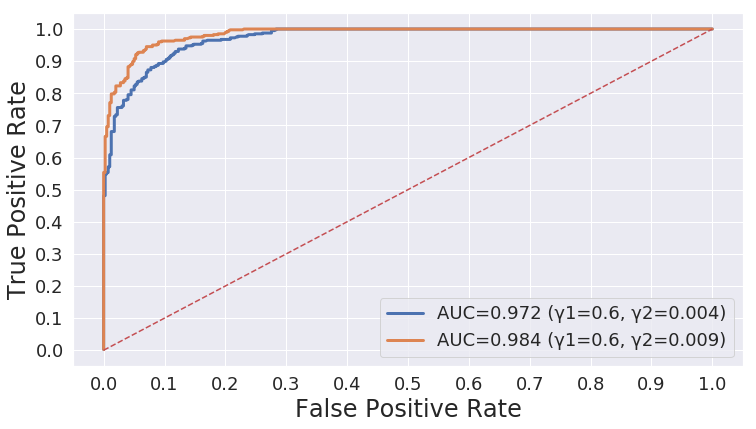

In [289]:
print(score.keys())

from sklearn import metrics
f, ax = plt.subplots(figsize=(12, 6.5))

labels = []
cccc = 0

keys = ['0.004_0.6', '0.009_0.6']
for key in keys:

    y = list(np.append(np.ones(cnt1, dtype=np.int32) * 1, np.ones(cnt2, dtype=np.int32) * 0))
    pred = list(np.append(score[key][0], score[key][1]))
             
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.plot(false_positive_rate, true_positive_rate, linewidth=3.0)
    labels.append('AUC={:.3f} (γ1={:.1f}, γ2={:.3f})'.format(roc_auc, float(key.split("_")[1]), float(key.split("_")[0])))
                
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 18}
legend = plt.legend(labels, prop=font)

plt.plot([0,1],[0,1],'r--')
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=18)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=18)

plt.ylabel('True Positive Rate', fontsize=24)
plt.xlabel('False Positive Rate', fontsize=24)
plt.show()

In [ ]:
# saving experiment pdf
f.savefig("experiment1_1.pdf", bbox_inches='tight')